# 1) Hardware Efficiency Factor (HEF) Modelling

In [2]:
import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 
#from functions import *
data=pd.read_csv('dataForTransformerHEF.csv', skiprows=None,usecols=None) 


In [5]:
data.columns

Index(['Unnamed: 0', 'operation', 'gpu_util', 'mem_used_MB',
       'elapsed_time_sec', 'FLOPs', 'energy_consumed_kWh',
       'total_gpu_energy_kWh', 'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'seq_len', 'memory_access', 'd_model', 'source', 'peak',
       'flops_per_second', 'HEF', 'component'],
      dtype='object')

In [3]:
Counter(data['component'])

Counter({'Projections': 1200,
         'Attention Scores': 600,
         'attention_softmax': 600,
         'Attention Output': 600})

In [4]:
pd.crosstab(data['source'],data['d_model'])

d_model,128,192,256,320,384,448,512,576,640,704,768,832,896,960,1024,1088,1152,1216,1280,1344
source,,,,,,,,,,,,,,,,,,,,
NVIDIA A100 80GB PCIe,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
NVIDIA GeForce RTX 2080 Ti,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50


In [3]:

def exponential_decay(x, L, k,d):
    return L * (1 - np.exp(-k * x**d))

def plot_exponential_decay_fit(data, x_col, y_col, **kwargs):
    source=data['source'].values[-1]
    op=data['component'].values[-1]
    # Extract x and y from the dataframe subset
    x = data[x_col].values
    y = data[y_col].values
    initial_guess = [60, 1,5]
    # Fit the custom exponential function to this subset
    popt, _ = curve_fit(exponential_decay, x, y, p0=initial_guess, maxfev=100000)
    L, k,d=popt[0],popt[1],popt[2]    

    # Plot the raw data
    plt.scatter(x*1e12, y, **kwargs)
    # Plot the fitted curve (using the same x values)
    fitted_y = exponential_decay(x, *popt)

    plt.scatter(x*1e12, fitted_y, color="red", marker='x',
            label=rf"$\eta_h = {L:.2f} \cdot \left(1 - e^{{-{k:.2f} \cdot C^{{{d:.2f}}}}}\right)$")

    #######################################################################################
    # Add legend if desired (each Facet gets its own legend)
    plt.legend()
    print(f"Source={source}, coef {op}, :{popt}")
    return popt

## HEF for Transformers components

/tmp/ipykernel_5857/330694214.py:2: RuntimeWarning: overflow encountered in power
  return L * (1 - np.exp(-k * x**d))
/tmp/ipykernel_5857/330694214.py:2: RuntimeWarning: overflow encountered in multiply
  return L * (1 - np.exp(-k * x**d))
/tmp/ipykernel_5857/330694214.py:2: RuntimeWarning: overflow encountered in exp
  return L * (1 - np.exp(-k * x**d))
/tmp/ipykernel_5857/330694214.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(exponential_decay, x, y, p0=initial_guess, maxfev=100000)


Source=NVIDIA A100 80GB PCIe, coef Projections, :[67.27125007  8.25990031  0.74983018]
Source=NVIDIA GeForce RTX 2080 Ti, coef Projections, :[73.6008     16.15185751 -4.52958036]
Source=NVIDIA A100 80GB PCIe, coef Attention Scores, :[58.17894823  7.17452486  0.77748618]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Scores, :[72.29630321 11.67924909  0.49973967]
Source=NVIDIA A100 80GB PCIe, coef Attention Output, :[66.48626194  8.60609864  0.78919595]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Output, :[78.63334535 19.40170615  0.54321314]


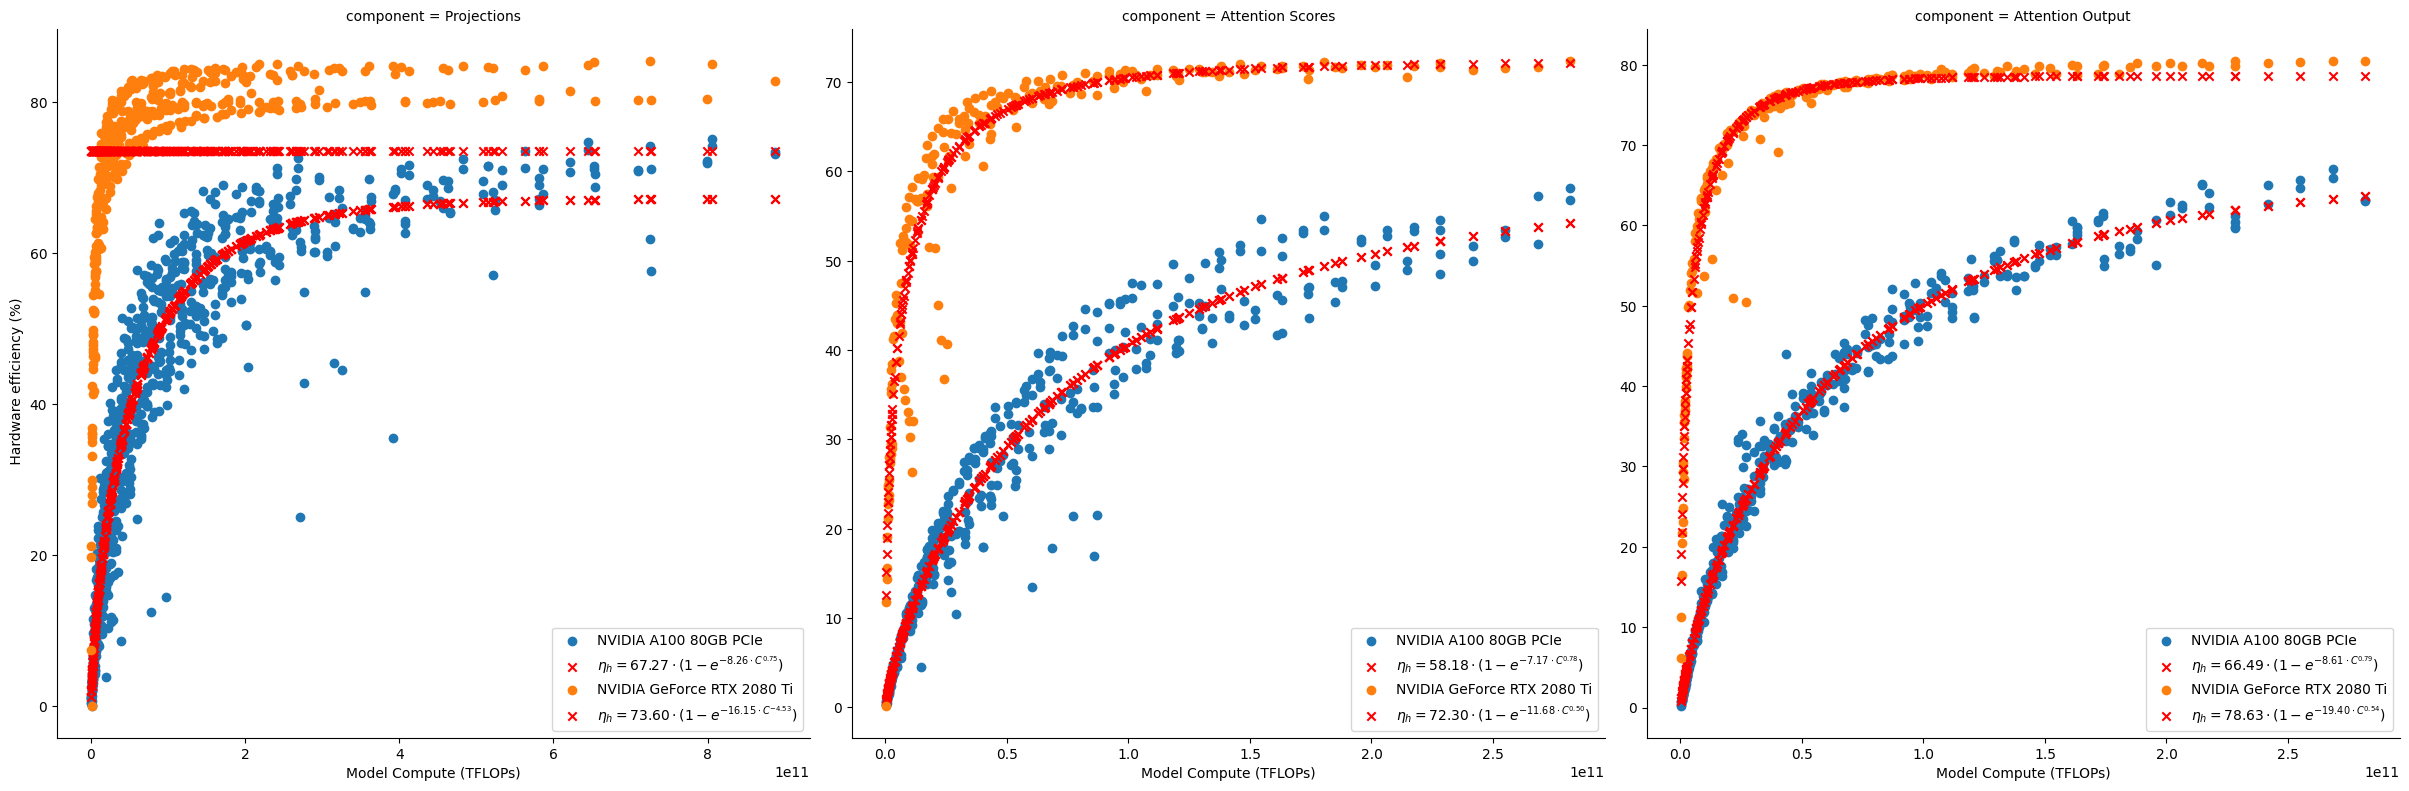

In [6]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

df=data[data['operation']!='attention_softmax'].copy()

a100=df[df['source']=='NVIDIA A100 80GB PCIe'].copy()

a100 = exclude_outliers_by_trend(
    a100,
    group_col='component',
    value_col='HEF',
    num_std=2
)

grid=df[df['source']!='NVIDIA A100 80GB PCIe'].copy()
grid = exclude_outliers_by_trend(
    grid,
    group_col='component',
    value_col='HEF',
    window_size=5,
    num_std=2
)
df=pd.concat([a100,grid],axis=0)


df["FLOPs"]=df["FLOPs"]/1e12

g = sns.FacetGrid(df, col="component",  hue="source",col_wrap=3, height=8, sharex=False, sharey=False)

g.map_dataframe(plot_exponential_decay_fit, x_col="FLOPs", y_col="HEF", data=df)
for ax in g.axes.flat:
    ax.legend(loc="best")  # Customize legend position
g.set_axis_labels("Model Compute (TFLOPs)", " Hardware efficiency (%)")

plt.show()

In [37]:
a100.columns

Index(['Unnamed: 0', 'operation', 'gpu_util', 'mem_used_MB',
       'elapsed_time_sec', 'FLOPs', 'energy_consumed_kWh',
       'total_gpu_energy_kWh', 'total_cpu_energy_kWh', 'total_ram_energy_kWh',
       'seq_len', 'memory_access', 'd_model', 'source', 'peak',
       'flops_per_second', 'HEF', 'component', 'rolling_mean', 'difference'],
      dtype='object')

/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in power
  return L * (1 - np.exp(-k * x**d))
/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in multiply
  return L * (1 - np.exp(-k * x**d))
/home/mmayaki/ml/hef/ECAI2025/functions.py:58: RuntimeWarning: overflow encountered in exp
  return L * (1 - np.exp(-k * x**d))


Source=NVIDIA A100 80GB PCIe, coef Attention Output, :[66.82779054  8.65310216  0.79642209]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Output, :[78.55340404 21.77292761  0.55853898]
Source=NVIDIA A100 80GB PCIe, coef Attention Scores, :[56.46769006  8.09405569  0.79619148]
Source=NVIDIA GeForce RTX 2080 Ti, coef Attention Scores, :[71.4216317  14.24767331  0.52060786]
Source=NVIDIA A100 80GB PCIe, coef Projections, :[69.37828569 10.36562148  0.78030791]
Source=NVIDIA GeForce RTX 2080 Ti, coef Projections, :[81.45293116 18.93959993  0.52092259]
Source=NVIDIA A100 80GB PCIe, coef Projections, :[70.43456236  6.2367522   0.76679027]
Source=NVIDIA GeForce RTX 2080 Ti, coef Projections, :[81.9320333   9.21027925  0.40250918]


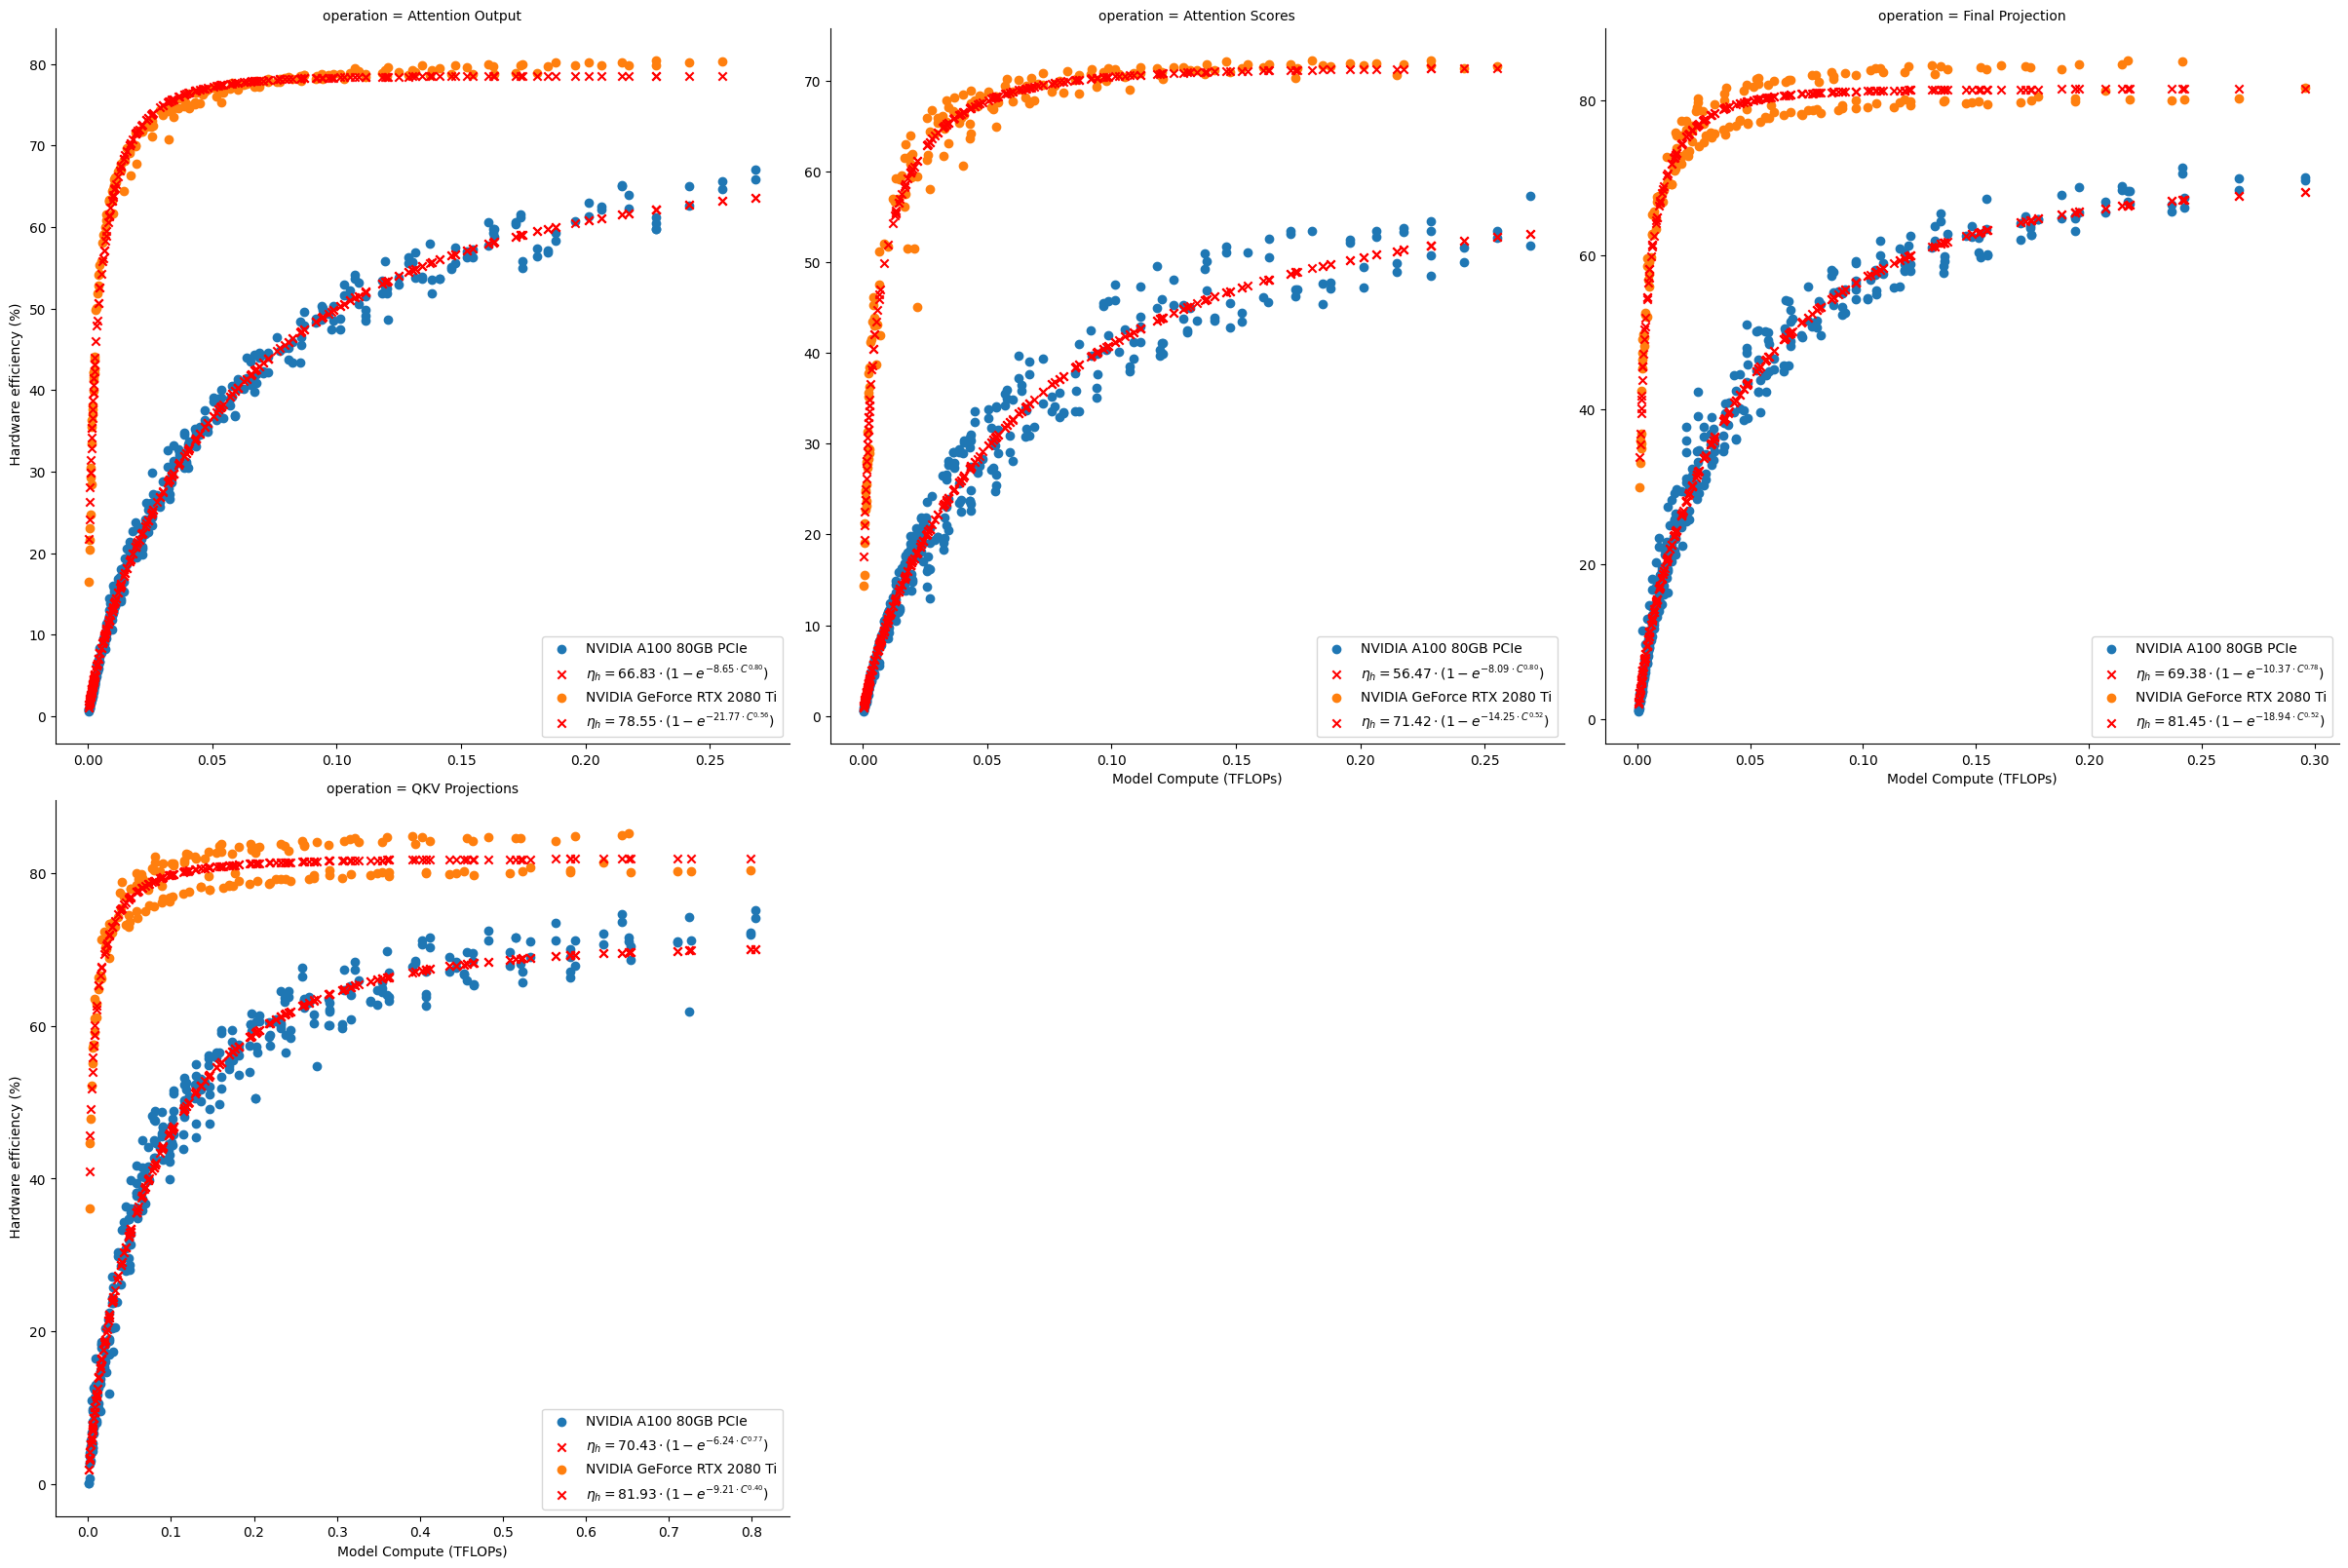

In [7]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

def plot_exponential_decay_fit(data, x_col, y_col, **kwargs):
    source=data['source'].values[-1]
    op=data['component'].values[-1]
    # Extract x and y from the dataframe subset
    x = data[x_col].values
    y = data[y_col].values
    initial_guess = [70, 1,5]
    # Fit the custom exponential function to this subset
    popt, _ = curve_fit(exponential_decay, x, y, p0=initial_guess, maxfev=100000)
    L, k,d=popt[0],popt[1],popt[2]
    

    # Plot the raw data
    plt.scatter(x, y, **kwargs)
    # Plot the fitted curve (using the same x values)
    fitted_y = exponential_decay(x, *popt)
    plt.scatter(x, fitted_y, color="red", marker='x',
            label=rf"$\eta_h = {L:.2f} \cdot \left(1 - e^{{-{k:.2f} \cdot C^{{{d:.2f}}}}}\right)$")

    #########################################################

    #######################################################################################
    # Add legend if desired (each Facet gets its own legend)
    plt.legend()
    print(f"Source={source}, coef {op}, :{popt}")
    return popt

df=data[data['operation']!='attention_softmax'].copy()

a100=df[df['source']=='NVIDIA A100 80GB PCIe'].copy()
a100 = exclude_outliers_by_trend(
    a100,
    group_col='component',
    value_col='HEF',
    num_std=2
)

grid=df[df['source']!='NVIDIA A100 80GB PCIe'].copy()
grid = exclude_outliers_by_trend(
    grid,
    group_col='component',
    value_col='HEF',
    window_size=5,
    num_std=2
)
df=pd.concat([a100,grid],axis=0)


df["FLOPs"]=df["FLOPs"]/1e12

g = sns.FacetGrid(df, col="operation",  hue="source",col_wrap=3, height=8, sharex=False, sharey=False)

g.map_dataframe(plot_exponential_decay_fit, x_col="FLOPs", y_col="HEF", data=df)
for ax in g.axes.flat:
    ax.legend(loc="best")  # Customize legend position
# If you need to adjust spacing or add a main title:
#g.fig.suptitle("Hardware Efficiency vs FLOPs by Model", y=1.05)
g.set_axis_labels("Model Compute (TFLOPs)", " Hardware efficiency (%)")

plt.show()

# HEF for LSTM AND GRU

In [4]:
import pandas as pd 
import pickle
import importlib
import matplotlib.pyplot as plt
import datetime
import os
import numpy as np
import seaborn as sns
from collections import Counter 


dataForLstmHEF=pd.read_csv('dataForLstmHEF.csv', skiprows=None,usecols=None) # transformer_11122024_16H_metrics transformer_11122024_15H_metricsCentaure transformer_16122024_22H_metricsCenature
dataForLstmHEF.head()

,Unnamed: 0,source,batch_size,input_size,hidden_size,component,gpu_util,mem_used_MB,elapsed_time_sec,FLOPs,energy_consumed_kWh,total_gpu_energy_kWh,total_cpu_energy_kWh,total_ram_energy_kWh,seq_len,peak,flops_per_second,HEF
0,0,NVIDIA A100 80GB PCIe,64,64,64,Activations,0,1111,0.006912,16384,0.000113,0.000066,0.000033,0.000015,4,1.560000e+14,2.370370e+06,0.000002
1,1,NVIDIA A100 80GB PCIe,64,64,64,Cell Update,0,1111,0.005182,8192,0.000118,0.000068,0.000034,0.000015,4,1.560000e+14,1.580715e+06,0.000001
2,2,NVIDIA A100 80GB PCIe,64,64,64,Hidden Update,0,1111,0.000206,8192,0.000123,0.000072,0.000036,0.000016,4,1.560000e+14,3.980099e+07,0.000026
3,3,NVIDIA A100 80GB PCIe,64,64,64,compute_gates,0,1111,0.000336,2097152,0.000108,0.000062,0.000031,0.000014,4,1.560000e+14,6.243903e+09,0.004003
4,4,NVIDIA A100 80GB PCIe,64,64,64,hidden_gates,0,1111,0.000226,2097152,0.000102,0.000059,0.000030,0.000013,4,1.560000e+14,9.266969e+09,0.005940


In [5]:
Counter(dataForLstmHEF['component'])

Counter({'Activations': 2280,
         'Cell Update': 2280,
         'Hidden Update': 2280,
         'compute_gates': 2280,
         'hidden_gates': 2280})

In [6]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['hidden_size'])

hidden_size,64,128,192,256,320,384,448,512,576,640,...,5760,6400,9600,12800,16000,19200,22400,25600,28800,32000
source,,,,,,,,,,,,,,,,,,,,,
NVIDIA A100 80GB PCIe,400,400,400,400,400,400,400,400,400,450,...,50,50,50,50,50,50,50,50,50,50
NVIDIA GeForce RTX 2080 Ti,200,200,200,200,200,200,200,200,200,650,...,450,450,0,0,0,0,0,0,0,0


In [7]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['input_size'])

input_size,64,128,192,256,320,384,448,512,576,640
source,,,,,,,,,,
NVIDIA A100 80GB PCIe,400,400,400,400,400,400,400,400,400,1300
NVIDIA GeForce RTX 2080 Ti,650,650,650,650,650,650,650,650,650,650


In [8]:
pd.crosstab(dataForLstmHEF['source'],dataForLstmHEF['component'])

component,Activations,Cell Update,Hidden Update,compute_gates,hidden_gates
source,,,,,
NVIDIA A100 80GB PCIe,980,980,980,980,980
NVIDIA GeForce RTX 2080 Ti,1300,1300,1300,1300,1300


## LSTM HEF Modeling

Source=NVIDIA A100 80GB PCIe, coef Activations, :[9.64757989e-02 1.75442841e+04 9.40970267e-01]
Source=NVIDIA A100 80GB PCIe, coef Cell Update, :[5.53963177e-02 1.28238784e+04 8.76974773e-01]
Source=NVIDIA A100 80GB PCIe, coef Hidden Update, :[9.76856105e-02 1.02866994e+04 8.91797967e-01]
Source=NVIDIA A100 80GB PCIe, coef compute_gates, :[41.02787983 21.57095764  0.86167851]
Source=NVIDIA A100 80GB PCIe, coef hidden_gates, :[80.03886545 10.08345805  0.79205334]


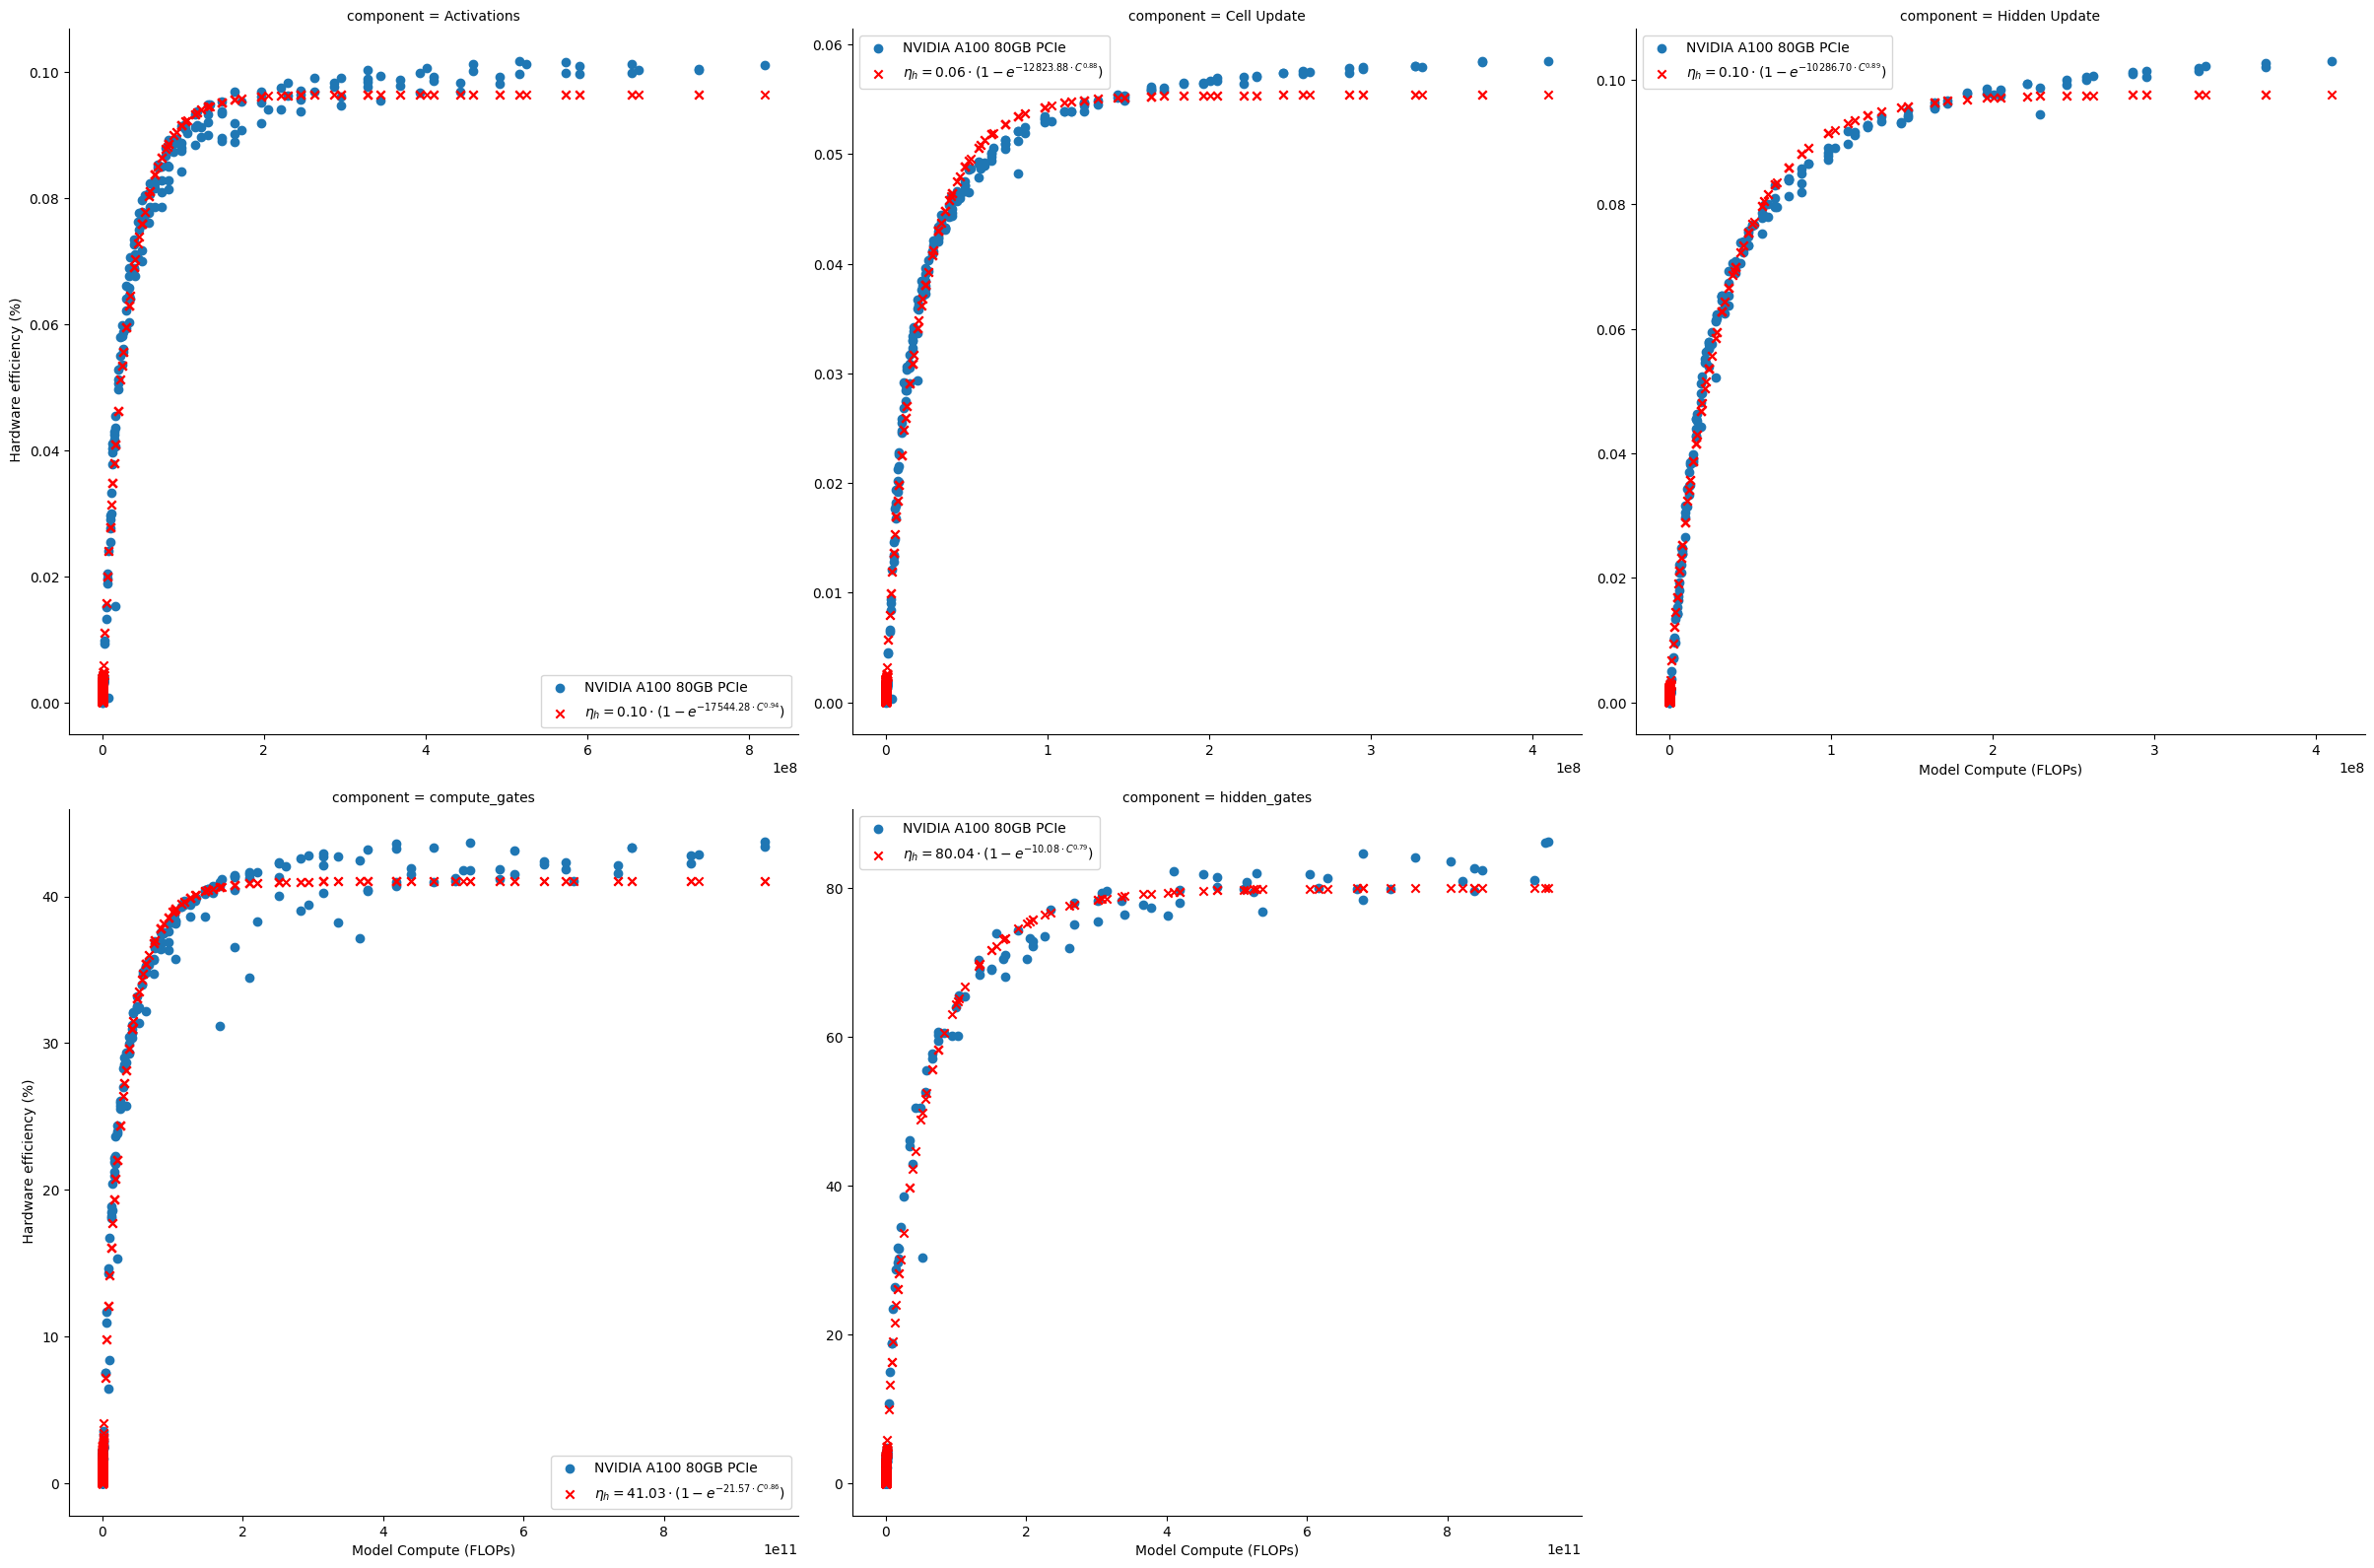

In [10]:
## Centaure très sensible au input_size
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
a100=dataForLstmHEF[dataForLstmHEF['source']=='NVIDIA A100 80GB PCIe'].copy()

a100["FLOPs"] /= 1e12
a100=a100[a100["FLOPs"]<1].copy()

g = sns.FacetGrid(a100, col="component",  hue="source",col_wrap=3, height=8, sharex=False, sharey=False)

g.map_dataframe(plot_exponential_decay_fit, x_col="FLOPs", y_col="HEF", data=a100)
for ax in g.axes.flat:
    ax.legend(loc="best")  # Customize legend position
g.set_axis_labels("Model Compute (FLOPs)", " Hardware efficiency (%)")
#plt.savefig("HEF_estimate_RNNs_.png")

plt.show()